**Muhammad Muhibuddin Mukhlish**

**M128D5Y1317**

In [1]:
# Import library standar
!pip install tensorflowjs
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import BatchNormalization
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import tensorflowjs as tfjs
from sklearn.model_selection import train_test_split
import glob

# Cek versi TensorFlow
print("TensorFlow Version:", tf.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.5.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
pandas-gbq 0.29.1 requires google-api-core<3.0.0,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompati

2025-09-20 15:03:03.129187: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758380583.325952      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758380583.384100      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow Version: 2.18.0


In [2]:
# --- Path Dataset Asli ---
base_dir_asli = '/kaggle/input/intel-image-classification'
train_dir_asli = os.path.join(base_dir_asli, 'seg_train', 'seg_train')
test_dir_asli = os.path.join(base_dir_asli, 'seg_test', 'seg_test')
pred_dir_asli = os.path.join(base_dir_asli, 'seg_pred', 'seg_pred')

# --- Path Dataset Baru (Setelah Digabung dan Dibagi) ---
base_dir_baru = '/kaggle/working/dataset_baru'
train_dir = os.path.join(base_dir_baru, 'train')
validation_dir = os.path.join(base_dir_baru, 'validation')
test_dir = os.path.join(base_dir_baru, 'test')

# Parameter untuk model
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 64

In [3]:
# --- 1. Menggabungkan Semua Gambar ke Direktori Sementara ---
all_images_dir = '/kaggle/working/all_images'
if os.path.exists(all_images_dir):
    shutil.rmtree(all_images_dir)
os.makedirs(all_images_dir)

# Daftar semua kelas dari salah satu folder asli
class_names = os.listdir(train_dir_asli)

# Salin semua gambar dari train dan test asli ke direktori gabungan
for cls in class_names:
    os.makedirs(os.path.join(all_images_dir, cls), exist_ok=True)
    # Salin dari folder train asli
    for img_path in glob.glob(os.path.join(train_dir_asli, cls, '*.jpg')):
        shutil.copy(img_path, os.path.join(all_images_dir, cls))
    # Salin dari folder test asli
    for img_path in glob.glob(os.path.join(test_dir_asli, cls, '*.jpg')):
        shutil.copy(img_path, os.path.join(all_images_dir, cls))

print("Semua gambar telah digabungkan.")

# --- 2. Menyiapkan Daftar File dan Label ---
image_paths = []
labels = []
for cls in class_names:
    for img_path in glob.glob(os.path.join(all_images_dir, cls, '*.jpg')):
        image_paths.append(img_path)
        labels.append(cls)

# --- 3. Melakukan Pembagian Dataset (Stratified Split) ---
# Rasio: 60% Train, 20% Validation, 20% Test
train_paths, val_test_paths, train_labels, val_test_labels = train_test_split(
    image_paths, labels, test_size=0.4, random_state=42, stratify=labels)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    val_test_paths, val_test_labels, test_size=0.5, random_state=42, stratify=val_test_labels)

print(f"Jumlah data train: {len(train_paths)}")
print(f"Jumlah data validation: {len(val_paths)}")
print(f"Jumlah data test: {len(test_paths)}")

# --- 4. Menyalin File ke Direktori Split yang Baru ---
if os.path.exists(base_dir_baru):
    shutil.rmtree(base_dir_baru)

def copy_files(paths, dest_folder):
    for path in paths:
        class_name = os.path.basename(os.path.dirname(path))
        os.makedirs(os.path.join(dest_folder, class_name), exist_ok=True)
        shutil.copy(path, os.path.join(dest_folder, class_name))

copy_files(train_paths, train_dir)
copy_files(val_paths, validation_dir)
copy_files(test_paths, test_dir)

print("Dataset berhasil dibagi menjadi train, validation, dan test set.")

Semua gambar telah digabungkan.
Jumlah data train: 10220
Jumlah data validation: 3407
Jumlah data test: 3407
Dataset berhasil dibagi menjadi train, validation, dan test set.


In [4]:
# Membuat ImageDataGenerator dengan augmentasi untuk data training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,      # DIKEMBALIKAN ke 30
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,         # DIKEMBALIKAN ke 0.2
    horizontal_flip=True,
    fill_mode='nearest'
)

# ImageDataGenerator untuk data validasi dan test (hanya rescale)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Menyiapkan data generator dari direktori baru
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 10220 images belonging to 6 classes.
Found 3407 images belonging to 6 classes.
Found 3407 images belonging to 6 classes.


In [5]:
base_model = MobileNetV2(weights='imagenet', include_top=False, 
                         input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# 2. Bekukan layer-layer dari base_model agar tidak ikut dilatih ulang
base_model.trainable = False

# 3. Bangun model Sequential baru di atas base_model
model = Sequential([
    # Base model yang sudah "ahli"
    base_model,
    
    # Kriteria Wajib: Menambahkan layer Conv2D dan Pooling
    # Kita letakkan setelah base model untuk memproses fitur yang diekstraksi
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Layer untuk meratakan output sebelum ke layer Dense
    GlobalAveragePooling2D(),
    
    # Layer klasifikasi custom kita
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

# Menampilkan ringkasan arsitektur baru
model.summary()

# 4. Compile model dengan optimizer Adam
# Kita bisa gunakan learning rate yang terbukti cukup baik sebelumnya
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/tmp/ipykernel_36/2987831333.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False,
I0000 00:00:1758380710.217880      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758380710.218613      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 3, 3, 64)       │       737,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,033,734 (11.57 MB)

 Trainable params: 774,726 (2.96 MB)

 Non-trainable params: 2,259,008 (8.62 MB)

In [6]:
# --- PERBAIKAN: Patience Ditingkatkan ---
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=8, # Memberi lebih banyak kesempatan pada model
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau tetap sama
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [7]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=50, # Set epoch yang cukup banyak, EarlyStopping akan menghentikannya jika sudah optimal
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1758380721.049686     126 service.cc:148] XLA service 0x7ab5d8111d40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758380721.050845     126 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758380721.050875     126 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758380722.030960     126 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/159 ━━━━━━━━━━━━━━━━━━━━ 37:22 14s/step - accuracy: 0.2344 - loss: 2.7304

I0000 00:00:1758380727.402814     126 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


159/159 ━━━━━━━━━━━━━━━━━━━━ 75s 384ms/step - accuracy: 0.6802 - loss: 0.9318 - val_accuracy: 0.8700 - val_loss: 0.4125 - learning_rate: 5.0000e-04
Epoch 2/50
  1/159 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8125 - loss: 0.6174

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8125 - loss: 0.6174 - val_accuracy: 0.8726 - val_loss: 0.4065 - learning_rate: 5.0000e-04
Epoch 3/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 53s 331ms/step - accuracy: 0.8321 - loss: 0.4956 - val_accuracy: 0.8614 - val_loss: 0.4035 - learning_rate: 5.0000e-04
Epoch 4/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8125 - loss: 0.6936 - val_accuracy: 0.8606 - val_loss: 0.4033 - learning_rate: 5.0000e-04
Epoch 5/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 54s 338ms/step - accuracy: 0.8459 - loss: 0.4326 - val_accuracy: 0.8930 - val_loss: 0.3130 - learning_rate: 5.0000e-04
Epoch 6/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9062 - loss: 0.3406 - val_accuracy: 0.8912 - val_loss: 0.3205 - learning_rate: 5.0000e-04
Epoch 7/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 53s 333ms/step - accuracy: 0.8520 - loss: 0.4131 - val_accuracy: 0.8812 - val_loss: 0.3485 - learning_rate: 5.0000e-04
Epoch 8/50
  1/159 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy

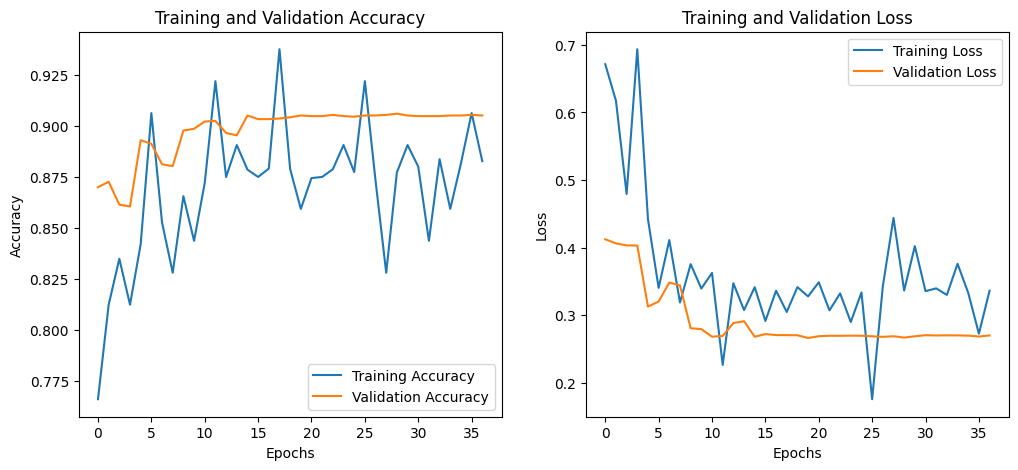


Evaluasi Model pada Data Test:
54/54 - 5s - 98ms/step - accuracy: 0.9037 - loss: 0.2619
Akurasi pada data test: 90.37%


In [8]:
# --- Plot Akurasi dan Loss ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

# --- Evaluasi Model pada Data Test ---
print("\nEvaluasi Model pada Data Test:")
loss_test, acc_test = model.evaluate(test_generator, verbose=2)
print(f"Akurasi pada data test: {acc_test*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


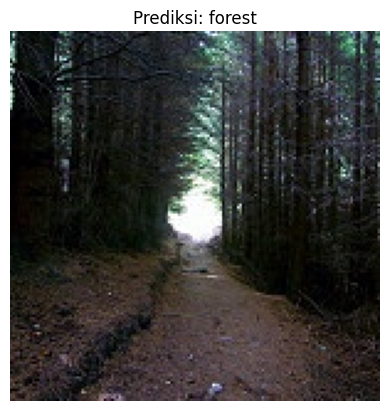

Gambar: 23979.jpg
Hasil Prediksi: forest
Probabilitas: 100.00%


In [9]:
# Ambil satu path gambar acak dari folder test
pred_image_path = os.path.join(test_dir, os.listdir(test_dir)[0], os.listdir(os.path.join(test_dir, os.listdir(test_dir)[0]))[0])

# Load dan preprocess gambar
img = image.load_img(pred_image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0 # Normalisasi

# Lakukan prediksi
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction)
# Ambil nama kelas dari train_generator untuk mapping indeks ke nama
predicted_class_name = list(train_generator.class_indices.keys())[predicted_class_index]

# Tampilkan hasil
plt.imshow(img)
plt.title(f'Prediksi: {predicted_class_name}')
plt.axis('off')
plt.show()

print(f"Gambar: {pred_image_path.split('/')[-1]}")
print(f"Hasil Prediksi: {predicted_class_name}")
print(f"Probabilitas: {np.max(prediction)*100:.2f}%")

In [10]:
# Kriteria 7: Menyimpan Model ke Dalam Format SavedModel, TF-Lite dan TFJS

# 1. Menyimpan dalam format SavedModel
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)
print(f"Model berhasil disimpan di direktori: {export_dir}")

# 2. Mengonversi ke TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_path = 'model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)
print(f"Model TFLite berhasil disimpan sebagai: {tflite_model_path}")

# 3. Mengonversi ke TensorFlow.js

tfjs_target_dir = 'tfjs_model/'
tfjs.converters.save_keras_model(model, tfjs_target_dir)
print(f"Model TFJS berhasil disimpan di direktori: {tfjs_target_dir}")

Model berhasil disimpan di direktori: saved_model/


W0000 00:00:1758381824.697340      36 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1758381824.697374      36 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1758381824.785786      36 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


Model TFLite berhasil disimpan sebagai: model.tflite
failed to lookup keras version from the file,
    this is likely a weight only file
Model TFJS berhasil disimpan di direktori: tfjs_model/


In [11]:
# Mendapatkan daftar nama kelas dari generator
class_names = list(train_generator.class_indices.keys())

# Mengurutkan nama kelas (sebaiknya, meskipun flow_from_directory biasanya sudah mengurutkan)
class_names = sorted(class_names)

# Menyimpan nama kelas ke dalam file label.txt
with open('label.txt', 'w') as f:
    for class_name in class_names:
        f.write(class_name + '\n')

print("File label.txt berhasil dibuat!")
!cat label.txt # Menampilkan isi file untuk verifikasi

File label.txt berhasil dibuat!
buildings
forest
glacier
mountain
sea
street


In [12]:
!pip freeze > requirements.txt

In [13]:
%%writefile README.md
# Proyek Klasifikasi Gambar: Pemandangan Alam

Ini adalah proyek submission untuk kelas Belajar Machine Learning untuk Pemula.

## Detail Proyek
- **Dataset**: Intel Image Classification (Natural Scenes)
- **Pembagian Dataset**: 60% Train, 20% Validation, 20% Test (Stratified Split)
- **Arsitektur Model**: Convolutional Neural Network (CNN) dengan 5 layer konvolusi.
- **Target Akurasi**: Mencapai akurasi di atas 85% pada data test.

## Struktur Direktori
- `/saved_model`: Model dalam format SavedModel TensorFlow.
- `/tflite`: Model dalam format TensorFlow Lite.
- `/tfjs_model`: Model dalam format TensorFlow.js.
- `notebook.ipynb`: Notebook yang berisi semua langkah pengerjaan proyek.
- `README.md`: File ini.
- `requirements.txt`: Daftar dependensi library Python.

Writing README.md


In [14]:
# Pastikan berada di direktori kerja
%cd /kaggle/working/

# Membuat direktori submission
!mkdir -p submission/tflite
!mkdir -p submission/tfjs_model
!mkdir -p submission/saved_model

# Memindahkan file dan folder ke dalam struktur yang benar
!mv model.tflite submission/tflite/
!mv label.txt submission/tflite/  # <--- TAMBAHKAN BARIS INI
!mv tfjs_model/* submission/tfjs_model/
!mv saved_model/* submission/saved_model/
!cp /kaggle/input/intel-image-classification/seg_train/seg_train/buildings/0.jpg submission/notebook.ipynb # Ganti ini dengan file notebook asli Anda
!mv README.md submission/
!mv requirements.txt submission/

# Membuat file zip dari folder submission
!zip -r submission.zip submission

print("\nFile submission.zip berhasil dibuat!")

/kaggle/working
  adding: submission/ (stored 0%)
  adding: submission/saved_model/ (stored 0%)
  adding: submission/saved_model/assets/ (stored 0%)
  adding: submission/saved_model/variables/ (stored 0%)
  adding: submission/saved_model/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: submission/saved_model/variables/variables.index (deflated 77%)
  adding: submission/saved_model/fingerprint.pb (stored 0%)
  adding: submission/saved_model/saved_model.pb (deflated 92%)
  adding: submission/notebook.ipynb (stored 0%)
  adding: submission/requirements.txt (deflated 57%)
  adding: submission/tflite/ (stored 0%)
  adding: submission/tflite/model.tflite (deflated 81%)
  adding: submission/tflite/label.txt (deflated 4%)
  adding: submission/README.md (deflated 40%)
  adding: submission/tfjs_model/ (stored 0%)
  adding: submission/tfjs_model/group1-shard3of3.bin (deflated 7%)
  adding: submission/tfjs_model/group1-shard2of3.bin (deflated 7%)
  adding: submission/tfjs_model/grou